In [ ]:
import awkward as ak
import numpy as np
import os
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
import pandas as pd
plt.style.use("figures.mplstyle")
import sys

sys.path.append("/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/IceCube/sources/Heavy-Neutrino-Limits/src/HNLimits/")
print(sys.path)
from src.HNLimits import hnl_tools

# Directory containing parquet files
base_dir = "Data/SIREN/Output/SINE_CMS_West/HNLs/"

# Regex to extract m4 and Um4 from filename
pattern = re.compile(r"m4_(\d+)_Um4_([0-9.]+)")

# Group files by (m4, Um4)
groups = defaultdict(list)
for fname in os.listdir(base_dir):
    if fname.endswith(".parquet"):
        match = pattern.search(fname)
        if match:
            m4 = match.group(1)
            Um4 = match.group(2).rstrip('.')
            groups[(m4, Um4)].append(os.path.join(base_dir, fname))

print(groups)


defaultdict(<class 'list'>, {('1500', '0.00695'): ['Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_light_-14_NC_m4_1500_Um4_0.00695.parquet', 'Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_charm_14_NC_m4_1500_Um4_0.00695.parquet', 'Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_charm_-14_NC_m4_1500_Um4_0.00695.parquet', 'Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_light_14_NC_m4_1500_Um4_0.00695.parquet'], ('0900', '0.00428'): ['Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_light_-14_NC_m4_0900_Um4_0.00428.parquet', 'Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_charm_14_NC_m4_0900_Um4_0.00428.parquet', 'Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_charm_-14_NC_m4_0900_Um4_0.00428.parquet', 'Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_light_14_NC_m4_0900_Um4_0.00428.parquet'], ('1000', '0.01833'): ['Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_charm_-14_NC_m4_1000_Um4_0.01833.parquet', 'Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_charm_14_NC_m4_1000_Um4_0.01833.parquet', 'Data/SIREN/Output/SINE_CMS_

In [20]:
def compute_time_delay(siren_data,
                       hnl_mass, # GeV
                       c=2.998e-1):
    """Compute time delay for each event:
    1. Neutrino: primary_initial_position → first vertex
    2. HNL: first vertex → second vertex
    3. Muon: second vertex → panel intersection

    Args:
        siren_data: awkward array with event data
        c: speed of light in mm/ns
    """

    nu_dict = {"first_plane_x":[],
            "first_plane_y": [],
            "first_plane_z": [],
            "second_plane_x": [],
            "second_plane_y": [],
            "second_plane_z": [],
            "weights":[],
            "beam_timing":[],
            "timing_difference":[],
            "hnl_delay":[],
            }

    # 3x2 setup
    panel_width = 24.4
    panel_height = 7.77
    panel_bottom = 0
    # prototype setup
    # panel_width = 12.2
    # panel_height = 2.59
    # panel_bottom = (7.77-2.59)/2

    # compute HNL beta
    hnl_momentum = siren_data["primary_momentum"][:,1,:]
    hnl_gamma = hnl_momentum[:,0] / hnl_mass
    hnl_beta = np.sqrt(1 - 1/(hnl_gamma**2))


    for plane in [1,2,3]:
        mask = siren_data["panel%d_hit_mask_muon0_survival"%(plane)]==1
        int_locations = siren_data[f"muon0_panel{plane}_int_locations"][mask]
        int_distances = np.squeeze(siren_data[f"muon0_panel{plane}_int_distances"][mask])
        vertices = np.squeeze(siren_data["vertex"][mask])
        initial_pos = np.squeeze(siren_data["primary_initial_position"][mask])
        wgts = np.squeeze(siren_data["weights"][mask])
        betas = np.squeeze(hnl_beta[mask])
        for w, init_pos, vx, dist, loc, beta in zip(wgts, initial_pos, vertices, int_distances, int_locations, betas):

            # # distance checks
            first_plane_y = loc[0][1] - panel_bottom
            second_plane_y = loc[1][1] - panel_bottom
            if first_plane_y > panel_height or first_plane_y < 0 : continue
            if second_plane_y > panel_height or second_plane_y < 0: continue
            if abs(loc[0][0]) > panel_width/2: continue
            if abs(loc[1][0]) > panel_width/2: continue
            if (loc[1][2] - loc[0][2]) <= 2.44 - 1e-6: continue # make sure we enter in front, exit in back

            # Time components:
            # print(vx[0])
            # print(vx[1])
            # print(dist[0])
            # print(loc[0])
            t_nu = np.linalg.norm(vx[0] - init_pos[0]) / c  # neutrino time
            t_hnl = np.linalg.norm(vx[1] - vx[0]) / (beta*c)    # HNL time
            t_muon = dist[0] / c                         # muon time in panel
            total_time = t_nu + t_hnl + t_muon
            # Light travel time from origin to intersection point
            light_time = np.linalg.norm(loc[0] - init_pos[0]) / c  # Time for light from initial neutrino position to hit point)

            nu_dict["beam_timing"].append(total_time)
            nu_dict["timing_difference"].append(total_time - light_time)
            nu_dict["first_plane_x"].append(loc[0][0])
            nu_dict["first_plane_y"].append(first_plane_y)
            nu_dict["first_plane_z"].append(loc[0][2])
            nu_dict["second_plane_x"].append(loc[1][0])
            nu_dict["second_plane_y"].append(second_plane_y)
            nu_dict["second_plane_z"].append(loc[1][2])
            nu_dict["weights"].append(w)
            nu_dict["hnl_delay"].append(t_hnl - (np.linalg.norm(vx[1] - vx[0]) / c))
    return nu_dict



In [12]:
example_data = ak.from_parquet(groups[('0900', '0.00428')][0])

In [60]:
example_data["max_deltaT"] = np.max(
    np.array(
    [example_data.muon0_panel1_timing_difference,
     example_data.muon0_panel2_timing_difference,
     example_data.muon0_panel3_timing_difference]).T,
     axis=1
     )
panel_transverse_disp = -np.ones((len(example_data),2))
mask = example_data.muon0_panel1_hit_mask
print(np.array(example_data.muon0_panel1_int_locations[mask]))
panel_transverse_disp[mask] = np.array(example_data.muon0_panel1_int_locations[mask])[:,1,:2] - np.array(example_data.muon0_panel1_int_locations[mask])[:,0,:2]
print(panel_transverse_disp)

[[[-3.48575177e+00  3.79514592e-01  1.83681862e+04]
  [-3.50840541e+00  4.88158973e-01  1.83706262e+04]]

 [[-8.59636887e-01  7.35257045e+00  1.83681862e+04]
  [-8.70174949e-01  7.39827750e+00  1.83706262e+04]]

 [[ 6.61296992e+00  3.17332772e+00  1.83681862e+04]
  [ 6.62541408e+00  3.22572263e+00  1.83706262e+04]]

 ...

 [[ 3.61307889e+00  2.63810630e+00  1.83681862e+04]
  [ 3.60316615e+00  2.72577163e+00  1.83706262e+04]]

 [[ 4.91581889e+00  9.29170533e-01  1.83681862e+04]
  [ 4.93041784e+00  9.74620749e-01  1.83706262e+04]]

 [[-2.59898923e+00  7.17340591e+00  1.83681862e+04]
  [-2.53183624e+00  7.25973764e+00  1.83706262e+04]]]
[[-0.02265365  0.10864438]
 [-0.01053806  0.04570705]
 [-1.         -1.        ]
 ...
 [ 0.06715299  0.08633173]
 [-1.         -1.        ]
 [-1.         -1.        ]]


In [130]:
# Compute sum for each group
deltaT_cut = 1
dimuon_rate = {}
delayed_rate = {}
muon_rate = {}
full_HNL_sim = {}
for i,((m4, Um4), files) in enumerate(groups.items()):
    if int(m4)>50000: continue
    # if float(Um4)>0.017: continue
    print("Processing group %d out of %d"%(i,len(groups)),end='\r')
    dimuon_total = 0.0
    delayed_total = 0.0
    muon_total = 0.0
    full_HNL_sim[(m4,Um4)] = ak.Array([])
    for f in files:
        data = ak.from_parquet(f)
        try:
            data["max_deltaT"] = np.max(
                np.array([data.muon0_panel1_timing_difference,
                          data.muon0_panel2_timing_difference,
                          data.muon0_panel3_timing_difference]).T,
                axis=1
                )
            for panel in range(1, 4):
                panel_transverse_disp = -np.ones((len(data),2))
                mask = data[f"muon0_panel{panel}_hit_mask"]==1
                panel_transverse_disp[mask] = np.array(data[f"muon0_panel{panel}_int_locations"][mask])[:,1,:2] - np.array(data[f"muon0_panel{panel}_int_locations"][mask])[:,0,:2]
                data[f"muon0_panel{panel}_transverse_disp"] = panel_transverse_disp

        except:
            print("Broke on %s"%f)
            continue
        # Make sure arrays are numpy for multiplication
        weights = np.array(data["weights"]*data["muon0_hit_mask_survival"]) # only surviving muons
        dimuon_mask = np.array(data["hit_mask_dimuon_survival"])
        delay_mask = np.array(data["max_deltaT"]>deltaT_cut)
        dimuon_total += np.sum(weights * dimuon_mask)
        delayed_total += np.sum(weights * delay_mask)
        muon_total += np.sum(weights)
        full_HNL_sim[(m4,Um4)] = ak.concatenate([full_HNL_sim[(m4,Um4)], data])
    dimuon_rate[(m4, Um4)] = dimuon_total
    delayed_rate[(m4, Um4)] = delayed_total
    muon_rate[(m4, Um4)] = muon_total

Broke on Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_light_-14_NC_m4_20000_Um4_0.00264.parquet
Broke on Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_charm_-14_NC_m4_15000_Um4_0.00264.parquet


In [131]:
m4_strings = np.unique([k[0] for k in dimuon_rate.keys()])
sort_idx = np.argsort(np.array(m4_strings,dtype=float))
m4_strings = m4_strings[sort_idx]
Um4_strings = np.unique([k[1] for k in dimuon_rate.keys()])
print(m4_strings)
print(Um4_strings)

['0700' '0800' '0900' '1000' '1500' '2000' '3000' '4000' '5000' '6000'
 '7000' '8000' '9000' '10000' '15000' '20000' '30000' '40000' '50000']
['0.00100' '0.00127' '0.00162' '0.00207' '0.00264' '0.00336' '0.00428'
 '0.00546' '0.00695' '0.00886' '0.01129' '0.01438' '0.01833' '0.02336'
 '0.02976' '0.03793' '0.04833' '0.06158' '0.07848' '0.10000']


/tmp/ipykernel_1418059/1904022145.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('plasma')  # You can use 'plasma', 'inferno', 'coolwarm', etc.


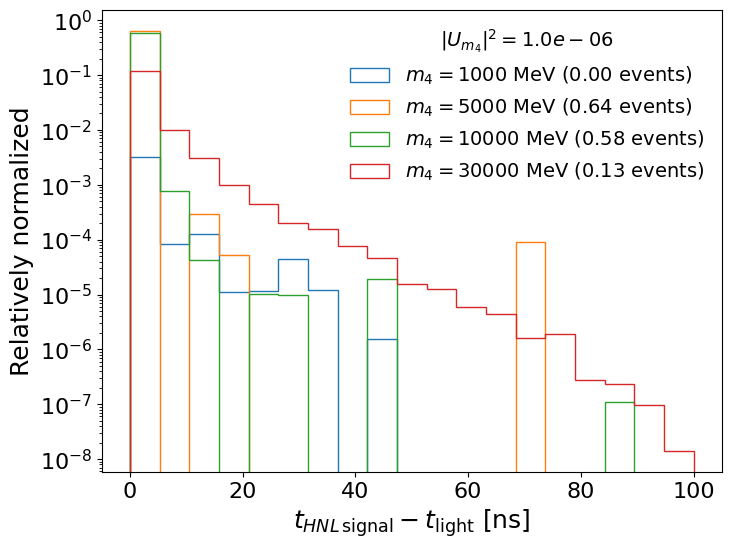

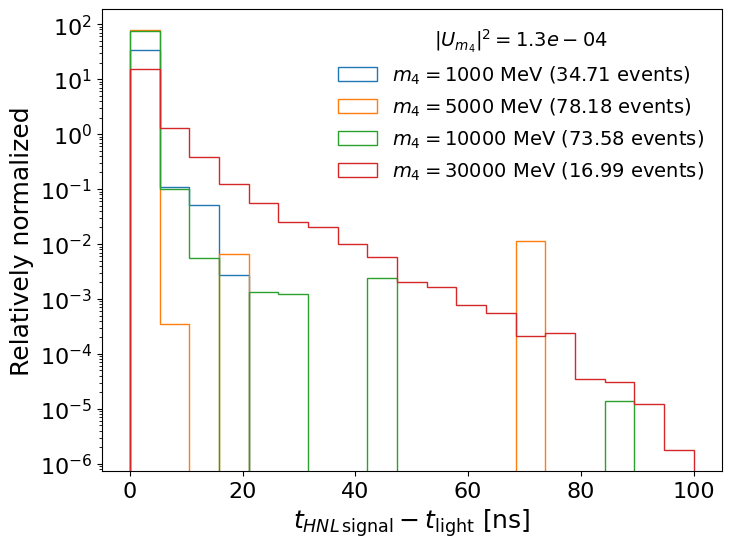

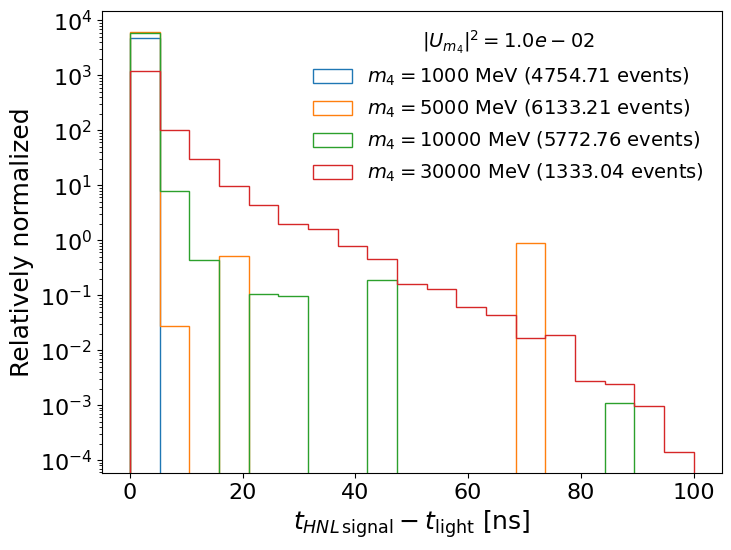

In [132]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

for Um4 in ["0.00100","0.01129","0.10000"]:
     # Create colormap
    cmap = cm.get_cmap('plasma')  # You can use 'plasma', 'inferno', 'coolwarm', etc.
    norm = mcolors.Normalize(vmin=float(m4_strings[0]), vmax=float(m4_strings[-1]))
    for m4 in ["1000","5000","10000","30000"]:
        k = (m4,Um4)
        color = cmap(norm(float(m4)))
        plt.hist(np.array(full_HNL_sim[k]["max_deltaT"]),
                     weights=full_HNL_sim[k]["weights"],
                     bins=np.linspace(0,100,20),
                     histtype="step",
                     label=r"$m_4=%s$ MeV (%1.2f events)"%(m4,sum(full_HNL_sim[k]["weights"])),
                     #color=color
                     )
    plt.xlabel(r"$t_{HNL \,{\rm signal}} - t_{\rm light}$ [ns]")
    plt.ylabel("Relatively normalized")
    plt.legend(loc="upper right",fontsize=14,title=r"$|U_{m_4}|^2=%1.1e$"%(float(Um4)**2))
    plt.semilogy()
    plt.show()

                                        plot_label  \
id                                                   
bebc                                          BEBC   
na3                                            NA3   
charmii                                   CHARM-II   
psi                                            PSI   
delphi_short                      DELPHI \\(short)   
nutev                                        NuTeV   
cms_2016                              CMS \\(8TeV)   
cms_2018_trilepton                    CMS \\(2018)   
cms_2018_dilepton            CMS \\(2018-dilepton)   
pienu_le                 PIENU\\(low $\mu$ energy)   
pienu_he                                     PIENU   
t2k                                            T2K   
t2k_lowmass              T2K \\(Arg\"uelles et al)   
atlas_2019_prompt                   ATLAS \\(2019)   
kek                                            KEK   
cosmo                                    Cosmology   
na62                        

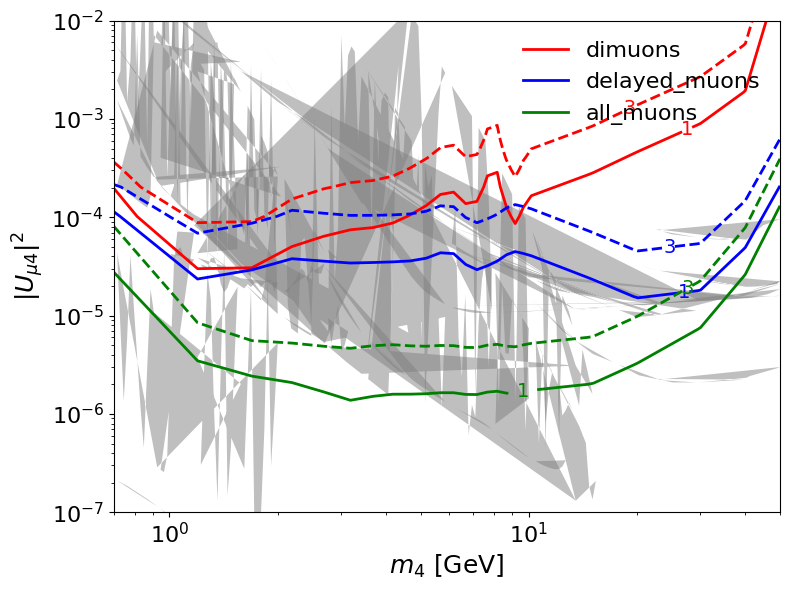

In [187]:
case_muon = hnl_tools.Limits(flavor='mu', invisible=False, nature='majorana')
print(case_muon.limits)

plt.figure(figsize=(8,6))

m4_range = np.logspace(np.log10(0.7),np.log10(50),200)

# first, plot existing limits
for case,limit in case_muon.limits.iterrows():
    x = m4_range
    y = limit.interp_func(m4_range)
    order = np.argsort(np.arctan2(y - y.mean(), x - x.mean()))
    #plt.scatter(x,y,color="gray")
    plt.fill(x[order], y[order], "gray", alpha=0.5)


# next, plot our sensitivity

for k,results in zip(["dimuons", "delayed_muons", "all_muons"],
                     [dimuon_rate, delayed_rate, muon_rate]):


    if k=="dimuons":
        color = "red"
    elif k=="delayed_muons":
        color = "blue"
    elif k=="all_muons":
        color = "green"


    # Prepare data
    m4_vals = np.array([int(k[0]) for k in results.keys()])/1e3 # GeV
    Um4_sq_vals = np.array([float(k[1])**2 for k in results.keys()])
    event_sums = np.array(list(results.values()))

    # Define grid for interpolation
    m4_grid = np.linspace(m4_vals.min(), m4_vals.max(), 100)
    Um4_sq_grid = np.linspace(Um4_sq_vals.min(), Um4_sq_vals.max(), 100)
    X, Y = np.meshgrid(m4_grid, Um4_sq_grid)

    # Interpolate event_sums onto grid
    Z = griddata((np.log10(m4_vals), np.log10(Um4_sq_vals)), np.log10(event_sums), (np.log10(X), np.log10(Y)), method='linear', fill_value=0)
    Z = 10**Z

    #pcm = plt.pcolormesh(X, Y, Z, cmap='viridis',norm=LogNorm())
    #sc = plt.scatter(m4_vals, Um4_sq_vals, c=event_sums, cmap='viridis', s=80,norm=LogNorm(vmin=5e-1,vmax=5))
    #plt.colorbar(sc, label='Number of HNL dimuons in SINE')
    contours = plt.contour(X, Y, Z, levels=[1,3],colors=[color],linestyles=["-","--"])
    plt.clabel(contours,fontsize=14)
    plt.plot([],[], color=color, label=k)
plt.xlabel(r'$m_4$ [GeV]')
plt.ylabel(r'$|U_{\mu 4}|^2$')
plt.loglog()
plt.ylim(1e-7,1e-2)
plt.tight_layout()
plt.legend()
plt.show()

# Cross section comparison

In [120]:
import siren
import os

cross_section_model = "HNLDISSplines"
xsfiledir = siren.utilities.get_cross_section_model_path(cross_section_model)

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon

nutype = "nu"
primary = 14
primary_type = (siren.dataclasses.Particle.ParticleType)(primary)

m4 = "0002000"
Ue4 = 0
Umu4 = 1
Utau4 = 0

HNL_DIS_xs = {}
for m4 in m4_strings:
    m4_str = f"{int(m4):07d}"
    HNL_DIS_xs[m4] = siren.interactions.HNLDISFromSpline(
        os.path.join(xsfiledir, "M_0000000MeV/dsdxdy-%s-N-nc-GRV98lo_patched_central.fits"%nutype),
        os.path.join(xsfiledir, "M_%sMeV/sigma-%s-N-nc-GRV98lo_patched_central.fits"%(m4_str,nutype)),
        float(m4)*1e-3,
        [Ue4,Umu4,Utau4],
        siren.utilities.Constants.isoscalarMass,
        1,
        [primary_type],
        [target_type],
    )

xsfiledir = "/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/pweigel/cross_sections/20241017"
# cross_section_model = "HNLDISSplines"
# xsfiledir = siren.utilities.get_cross_section_model_path(cross_section_model)

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon
nutype = "neutrino"
nuflavor = "muon"
minQ2 = 1

DIS_xs_NC = siren.interactions.DISFromSpline(
        os.path.join(xsfiledir, "wcg24b_dsdxdy_%s_%s_%s_isoscalar.fits"%("NC",nuflavor,nutype)),
        os.path.join(xsfiledir, "wcg24b_sigma_%s_%s_%s_isoscalar.fits"%("NC",nuflavor,nutype)),
        1,siren.utilities.Constants.isoscalarMass,minQ2,
        [primary_type],
        [target_type], "cm"
    )
DIS_xs_CC = siren.interactions.DISFromSpline(
        os.path.join(xsfiledir, "wcg24b_dsdxdy_%s_%s_%s_isoscalar.fits"%("CC",nuflavor,nutype)),
        os.path.join(xsfiledir, "wcg24b_sigma_%s_%s_%s_isoscalar.fits"%("CC",nuflavor,nutype)),
        1,siren.utilities.Constants.isoscalarMass,minQ2,
        [primary_type],
        [target_type], "cm"
    )

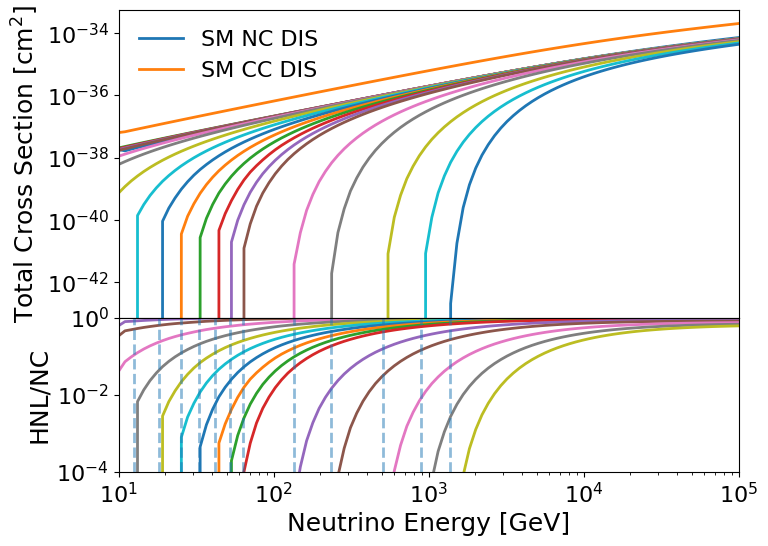

In [185]:
import matplotlib.gridspec as gridspec

# Create a custom grid layout
fig = plt.figure()
gs = gridspec.GridSpec(2,1, height_ratios=[1, 0.5], hspace=0)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax = [ax0,ax1]

e_range = np.logspace(1,5,100) # GeV
dis_xs_vals_NC = [DIS_xs_NC.TotalCrossSection(primary_type,E) for E in e_range] # cm^2
dis_xs_vals_CC = [DIS_xs_CC.TotalCrossSection(primary_type,E) for E in e_range] # cm^2
ax[0].plot(e_range,dis_xs_vals_NC,label="SM NC DIS")
ax[0].plot(e_range,dis_xs_vals_CC,label="SM CC DIS")
for m4_str,hnl_xs in HNL_DIS_xs.items():
    threshold = hnl_xs.InteractionThreshold(siren.dataclasses.InteractionRecord())
    hnl_xs_vals = [hnl_xs.TotalCrossSection(primary_type,E) if E > threshold else 0 for E in e_range] # cm^2
    ax[0].plot(e_range,hnl_xs_vals)
    ax[1].plot(e_range,np.array(hnl_xs_vals)/np.array(dis_xs_vals_NC))
    ax[1].axvline(threshold,ls="--",alpha=0.5)
ax[0].loglog()
ax[1].loglog()
ax[1].set_xlabel("Neutrino Energy [GeV]")
ax0.tick_params(bottom=False, labelbottom=False)
ax[0].set_ylabel(r"Total Cross Section [cm$^2$]")
ax[1].set_ylabel(r"HNL/NC")
ax[0].legend()
ax[0].set_xlim(e_range[0],e_range[-1])
ax[1].set_ylim(1e-4,1)

plt.show()

# Sandbox 

In [33]:
x = ak.from_parquet("/n/holylfs05/LABS/arguelles_delgado_lab/Everyone/nkamp/Geneva/Lake_Geneva_Neutrinos/Data/SIREN/Output/SINE_CMS_West/HNLs/SIBYLL_light_-14_NC_m4_4000_Um4_0.04833.parquet")

In [34]:
sum(x.weights*x.muon0_hit_mask_survival)

216.80551715743894

In [39]:
x.muon0_panel3_timing_difference

<Array [0, 2.22, 0, 0.163, 0, 0, ..., 0, 0, 0, 0, 0] type='33 * float64'>

In [51]:
x.muon0_panel1_hit_mask_survival

<Array [True, False, False, False, ..., True, True, True] type='33 * bool'>

In [55]:
np.array(x.muon0_panel1_hit_mask_survival,dtype=int) + np.array(x.muon0_panel2_hit_mask_survival,dtype=int) + np.array(x.muon0_panel3_hit_mask_survival,dtype=int)

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1])